In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import stats
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

# Custom functions 

In [2]:
import requests
import json
def get_pgs_anno_from_catalog(pgs_id: str) -> str | None:
    url = f'https://www.pgscatalog.org/rest/score/{pgs_id}'
    response = requests.get(url)
    anno = response.json()
    if 'trait_reported' in anno:
        return anno['trait_reported']
    elif 'description' in anno:
        return anno['description']
    else:
        return ''

def get_features_anno(df):
    return {
        col: get_pgs_anno_from_catalog(col.split('_')[0])
        for col in df.columns
    }

def top_n_corr_with_anno(X, y, n: int, plt_width=10, plt_height=6):
    corr = X.corrwith(y)
    abs_corr = corr.abs().sort_values(ascending=False)
    top_features = abs_corr.head(n).index
    top_features_names = [
        pgs.split('_')[0] + ' ' + get_pgs_anno_from_catalog(pgs.split('_')[0])
        for pgs in top_features
    ]
    plt.figure(figsize=(plt_width, plt_height))
    sns.barplot(x=abs_corr[top_features], y=top_features_names)
    plt.xlabel('Absolute Correlation with BMI')
    plt.ylabel('Features')
    plt.title(f'Top {n} Features Correlated with BMI')
    plt.show()

def reduce_to_top_n_correlated(X, y, n):
    corr = X.corrwith(y)
    abs_corr = corr.abs().sort_values(ascending=False)
    top_features = abs_corr.head(n).index
    return X[top_features]

## Save PGS Meta information 

In [3]:
def fetch_pgs_catalog_metadata(f='pgs_meta.json'):
    initial_url = 'https://www.pgscatalog.org/rest/score/all'
    full_meta = []

    url = initial_url
    page=1
    while url:
        print(f"Processing page {page}")
        response = requests.get(url)
        
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}")
            break
       
        data = response.json()
        scores = data.get('results', [])
        full_meta.extend(scores)
    
        if 'next' in data and data['next']:
            page+=1
            url = data.get('next')
        else:
            break  # No more pages, exit the loop
    print(f"Total number of scores fetched: {len(full_meta)}")
    return full_meta

## Local Metadata functions

In [4]:
def read_pgs_meta(file='pgs_meta.json'):
    with open(file, 'r') as f:
        meta = json.load(f)
        return meta

def create_pgs_meta_dict(file='pgs_meta.json'):
    with open(file, 'r') as f:
        meta = json.load(f)
        id_meta_dict = {}
        for pgs in meta:
            id_meta_dict[pgs.get('id')] = pgs
        return id_meta_dict

def get_id_trait_dict(meta=None):
    if meta is None:
        meta = read_pgs_meta()
    id_trait = {}
    for pgs in meta:
        id_trait[pgs.get('id')] = pgs.get('trait_reported')
    return id_trait

def get_pgs_trait(pgs_id):
    meta = get_id_trait_dict()
    return meta[pgs_id]

def annot_pgs_cols(df):
    meta = get_id_trait_dict()
    anno = {}
    for col in list(df.columns):
        pgs = col.split('_')[0]
        if pgs.startswith('PGS'):
            anno[col] = meta[pgs]
    return anno

def get_pgs_meta(pgs_id, id_meta_dict=None):
    
    if id_meta_dict is None:
        id_meta_dict = create_pgs_meta_dict()
    return id_meta_dict[pgs_id]

## Meta based filtration 

In [5]:
def filter_by_ancestry(df, ancestry, threshold):
    pgs_columns = [col for col in df.columns if col.startswith('PGS')]
    non_pgs_columns = list(set(df.columns) - set(pgs_columns))

    id_meta = create_pgs_meta_dict()

    final_columns = []

    for col in pgs_columns:
        pgs_id = col.split('_')[0]
        ancestry_info = id_meta[pgs_id]['ancestry_distribution']
        if 'dev' in ancestry_info:
            dist = ancestry_info['dev']['dist']
        
        elif 'eval' in ancestry_info:
            dist = ancestry_info['eval']['dist']
        
        elif 'gwas' in ancestry_info:
            dist = ancestry_info['gwas']['dist']
        else:
            trait = id_meta[pgs_id]['trait_reported']
            print(f'No ancestry distribution info found for {pgs_id} ({trait})')
            continue
        if ancestry in dist and dist[ancestry] >= threshold:
            final_columns.append(col)
    final_columns.extend(non_pgs_columns)
    return df[final_columns]

# Analysis 

## Read and prepare data 

In [6]:
df_orig = pd.read_csv('merged_avg.csv')

/tmp/ipykernel_101119/1824097721.py:1: DtypeWarning: Columns (0,4034) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv('merged_avg.csv')


In [11]:
useless_columns = ['ID', 'clusters', 'weight', 'height', 'ethnicity',
       'source', 'zscore_BMI_clasters', 'zscore_height_clasters',
       'PRS_by_claters_height', 'PRS_by_claters_bmi', 'IID', ]
df = df_orig.drop(useless_columns, axis=1)

In [12]:
X = df.drop(columns=['bmi'])
y = df['bmi']

## Extract top n features by correlation 

In [13]:
n = 200
top_n = reduce_to_top_n_correlated(df.drop(['sex', 'bmi', 'age'], axis=1), y , n)
features = list(top_n.columns) + ['sex', 'age']

/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [14]:
X_n = X[features]
y_cat = y.apply(lambda x: x < 25)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_n, y_cat, test_size=0.2, random_state=77)

## Catboost classification 

In [55]:
cat_features = ['sex']

In [61]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [62]:
param_distribution = {
    'one_hot_max_size': stats.bernoulli(p=0.2, loc=2),
    'learning_rate': stats.uniform(0.01, 0.1),
    'l2_leaf_reg': stats.uniform(1, 10),
    'depth': stats.binom(n=10, p=0.2),
    'boosting_type': ['Ordered', 'Plain']
}

model = CatBoostClassifier(iterations=1000, logging_level='Silent')

randomized_search_results_10 = model.randomized_search(
    param_distribution,
    train_pool,
    n_iter=10,
    shuffle=False,
    search_by_train_test_split=False,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Remove all BMI features 

In [126]:
n = 1000
top_n= reduce_to_top_n_correlated(df.drop(['sex', 'bmi', 'age'], axis=1), y, n)
anno = annot_pgs_cols(top_n)
no_bmi = {pgs: an for pgs, an in anno.items() if 'bmi' not in an.lower()}
no_bmi = list(no_bmi.keys())
features = no_bmi + ['sex', 'age']

/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [86]:
len(features)

924

In [172]:
X_n = X[features]
y_cat = y.apply(lambda x: x < 25)
X_train, X_test, y_train, y_test = train_test_split(X_n, y_cat, test_size=0.2, random_state=77)

In [88]:
cat_features = ['sex']
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

param_distribution = {
    'one_hot_max_size': stats.bernoulli(p=0.2, loc=2),
    'learning_rate': stats.uniform(0.01, 0.1),
    'l2_leaf_reg': stats.uniform(1, 10),
    'depth': stats.binom(n=10, p=0.2),
    'boosting_type': ['Ordered', 'Plain']
}

model = CatBoostClassifier(iterations=1000, logging_level='Silent')

randomized_search_results_10 = model.randomized_search(
    param_distribution,
    train_pool,
    n_iter=10,
    shuffle=False,
    search_by_train_test_split=False,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Filter by ancestry

In [15]:
n = 10
top_n= reduce_to_top_n_correlated(df.drop(['sex', 'bmi', 'age'], axis=1), y, n)
anno = annot_pgs_cols(top_n)
no_bmi = {pgs: an for pgs, an in anno.items() if 'bmi' not in an.lower()}
no_bmi = list(no_bmi.keys())
features = no_bmi + ['sex', 'age']

/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/musha/miniconda3/envs/skull/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [16]:
X_n = X[features]
X_n = filter_by_ancestry(X_n, 'EUR', 100)

X_train, X_test, y_train, y_test = train_test_split(X_n, y_cat, test_size=0.3, random_state=10)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=10)

In [17]:
cat_features = ['sex']
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

param_distribution = {
    'one_hot_max_size': stats.bernoulli(p=0.2, loc=2),
    'learning_rate': stats.uniform(0.01, 0.1),
    'l2_leaf_reg': stats.uniform(1, 10),
    'depth': stats.binom(n=10, p=0.2),
    'boosting_type': ['Ordered', 'Plain']
}

model = CatBoostClassifier(iterations=1000, logging_level='Silent')

randomized_search_results_10 = model.randomized_search(
    param_distribution,
    train_pool,
    n_iter=10,
    shuffle=False,
    search_by_train_test_split=False,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
randomized_search_results_10['params']

{'boosting_type': 'Ordered',
 'depth': 2,
 'one_hot_max_size': 2,
 'learning_rate': 0.04931754044187755,
 'l2_leaf_reg': 7.534502931951519}

In [19]:
train_pool = Pool(X_train, y_train, cat_features=['sex'])
test_pool = Pool(X_test, y_test, cat_features=['sex'])
val_pool = Pool(X_val, y_val, cat_features=['sex'])

In [20]:
def calculate_test_quality(train_pool=train_pool, val_pool=val_pool, test_pool=test_pool, **kwargs):
    model = CatBoostClassifier(**kwargs, random_seed=42, cat_features=['sex'])
    model.fit(train_pool, verbose=0, eval_set=val_pool)
    y_pred = model.predict_proba(test_pool)
    return eval_metric(test_pool.get_label(), y_pred[:, 1], 'AUC')

In [21]:
random_search_params = {
    'boosting_type': 'Ordered',
 'depth': 1,
 'one_hot_max_size': 2,
 'learning_rate': 0.04658589582322253,
 'l2_leaf_reg': 9.140370431505685
}

In [22]:
calculate_test_quality(**randomized_search_results_10['params'])

[0.7518532684283727]

In [41]:
feature_importance_df = pd.DataFrame({
    'feature': X_n.columns, 
    'importance': model.get_feature_importance()
    #'shap': model.get_feature_importance(train_pool, type='ShapValues', reference_data=all_cat_pool)
})

feature_importance_df

,feature,importance
0,PGS000319_hmPOS_GRCh37,6.405804
1,PGS000318_hmPOS_GRCh37,13.703903
2,PGS003408_hmPOS_GRCh37,5.882710
3,sex,38.215001
4,age,35.792582


In [42]:
pgs_anno = annot_pgs_cols(X_n)
feature_importance_df['feature'] = feature_importance_df['feature'].replace(pgs_anno)

In [43]:
feature_importance_df

,feature,importance
0,All-cause mortality (male),6.405804
1,All-cause mortality (female),13.703903
2,Intracranial aneurysm,5.882710
3,sex,38.215001
4,age,35.792582


/tmp/ipykernel_101119/2680152743.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.sort_values(by='importance', ascending=False), palette='CMRmap')


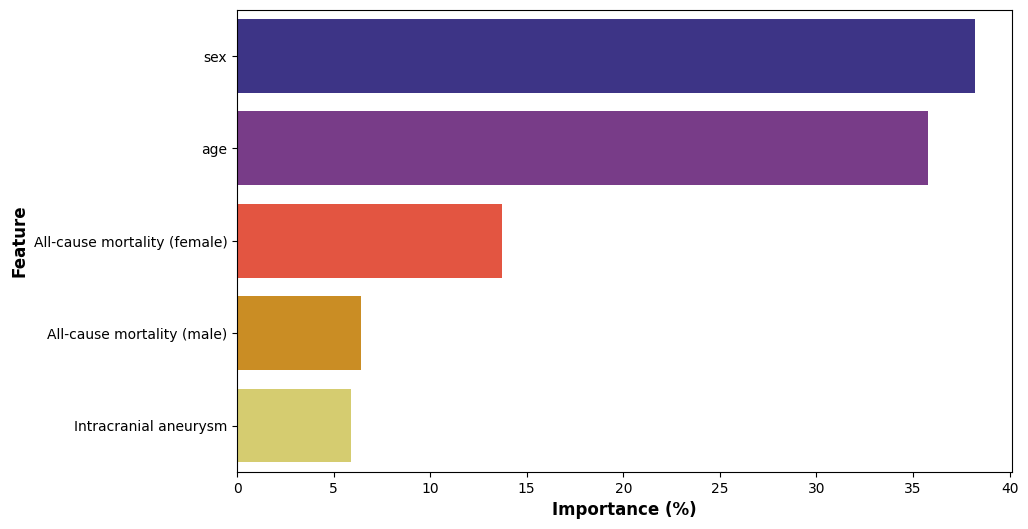

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.sort_values(by='importance', ascending=False), palette='CMRmap')
plt.xlabel('Importance (%)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.savefig('catboost_feature_importance.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [24]:
model_ctbst = CatBoostClassifier(**random_search_params, random_seed=42, cat_features=['sex'])
model_ctbst.fit(train_pool, verbose=0, eval_set=val_pool)

In [27]:
def roc_auc(model, train_pool=train_pool, val_pool=val_pool, test_pool=test_pool):
    y_pred_proba = model.predict_proba(test_pool)[::,1]
    
    y_pred = model.predict(test_pool)

    print("Accuracy", accuracy_score(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.savefig('roc_auc_catboost.pdf', bbox_inches='tight', format='pdf')
    plt.show()
    
    return eval_metric(test_pool.get_label(), y_pred_proba, 'AUC')

In [217]:
annot_pgs_cols(X_n)

{'PGS000319_hmPOS_GRCh37': 'All-cause mortality (male)',
 'PGS000318_hmPOS_GRCh37': 'All-cause mortality (female)',
 'PGS003408_hmPOS_GRCh37': 'Intracranial aneurysm'}

Accuracy 0.7015706806282722


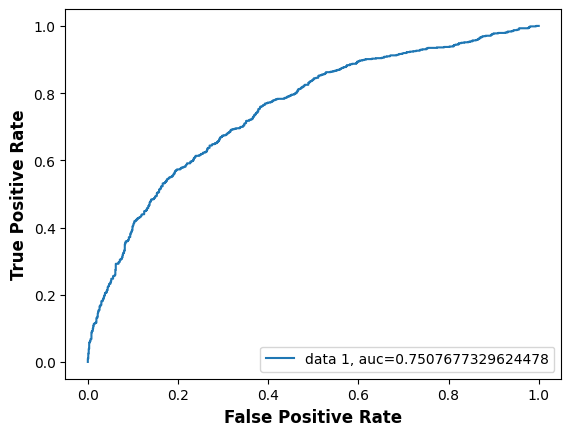

[0.7507677329624478]

In [28]:
roc_auc(model_ctbst)